In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import datetime
import pandas as pd
import random

from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Conv2DTranspose, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam


from tensorflow.keras import layers
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()
    ax1.plot(history['loss'], label='Training loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.legend()

    ax2.set_title('Accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax2.grid()
    ax2.plot(history['accuracy'], label='Training accuracy')
    ax2.plot(history['val_accuracy'], label='Validation accuracy')
    ax2.legend()

    plt.show()

def plot_resultados(model, carpeta, height=64, width=64, n=4):
    """
    Muestra comparaciones entre imágenes originales y reconstruidas por el autoencoder.
    """
    # Seleccionar imágenes aleatorias
    archivos = os.listdir(carpeta)
    archivos_img = random.sample(archivos, n)

    # Cargar y normalizar las imágenes
    imgs_originales = []
    for nombre in archivos_img:
        img = load_img(os.path.join(carpeta, nombre), target_size=(height, width))
        img_array = img_to_array(img) / 255.0  # normalizar a [0,1]
        imgs_originales.append(img_array)

    imgs_originales = np.array(imgs_originales)

    # Reconstruir con el modelo
    imgs_reconstruidas = model.predict(imgs_originales)

    # Mostrar resultados
    plt.figure(figsize=(12, 6))
    for i in range(n):
        # Imagen original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs_originales[i])
        ax.set_title("Original")
        ax.axis("off")

        # Imagen reconstruida
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(imgs_reconstruidas[i])
        ax.set_title("Reconstruida")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def mostrar_imagenes_generadas(modelo_generador, latent_dim=100, num_imagenes=4, image_size=(64, 64, 3)):
    """
    Genera y muestra imágenes lado a lado usando un modelo generador.

    Args:
        modelo_generador: modelo Keras que recibe un vector latente y devuelve una imagen.
        latent_dim: dimensión del vector latente.
        num_imagenes: número de imágenes a generar.
        image_size: tamaño esperado de las imágenes (solo usado si quieres validar forma).
    """
    # Generar vectores latentes aleatorios
    z = generateLatentDim(latent_dim, num_imagenes)

    # Generar imágenes con el modelo
    imagenes = modelo_generador.predict(z)

    # Mostrar imágenes en una fila
    fig, axes = plt.subplots(1, num_imagenes, figsize=(num_imagenes * 3, 3))
    for i, ax in enumerate(axes):
        ax.imshow(imagenes[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

2025-10-13 10:09:38.678629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760350178.912820      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760350178.969156      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# GAN

## Defining Hiperparameters

In [2]:
import os

os.listdir("/kaggle/input")

['images']

In [3]:
height, width = 64, 64 # Image size, to fit in the competition size
image_dir = '/kaggle/input'

latent_dim_size = 100
batch_size = 256

In [10]:
# Latent dim generator
def generateLatentDim(latent_dim_size=latent_dim_size, batch_size= batch_size):
    return np.random.randn(batch_size, latent_dim_size)

# Discriminator
disc_input = Input(shape=(height, width, 3)) 
x_disc = Conv2D(16, (3, 3), activation="relu", strides=1, padding="same")(disc_input)
x_disc = Conv2D(32, (3, 3), activation="relu", strides=1, padding="same")(x_disc)
x_disc = MaxPooling2D()(x_disc)
x_disc = Conv2D(64, (3, 3), activation="relu", strides=1, padding="same")(x_disc)
x_disc = Conv2D(128, (3, 3), activation="relu", strides=1, padding="same")(x_disc)
x_disc = Conv2D(256, (3, 3), activation="relu", strides=1, padding="same")(x_disc)
x_disc = Flatten()(x_disc)
x_disc = Dense(512, activation="relu")(x_disc)
x_disc = Dense(512, activation="relu")(x_disc)
classification = Dense(1, activation="sigmoid")(x_disc)

# Generator
gen_input = Input(shape=(latent_dim_size,))
x_gen = Dense(512*4*4)(gen_input)
x_gen= Reshape((4, 4, 512))(x_gen)
x_gen = Conv2DTranspose(256, (3, 3), activation="relu", strides=2, padding="same")(x_gen)
x_gen = Conv2DTranspose(128, (3, 3), activation="relu", strides=2, padding="same")(x_gen)
x_gen = Conv2DTranspose(64, (3, 3), activation="relu", strides=2, padding="same")(x_gen)
x_gen = Conv2DTranspose(32, (3, 3), activation="relu", strides=2, padding="same")(x_gen)
x_gen = Conv2DTranspose(16, (3, 3), activation="relu", strides=1, padding="same")(x_gen)
gen_image = Conv2DTranspose(3, (3, 3), activation="sigmoid", padding="same")(x_gen)

We define the autoencoder, encoder and decoder

In [11]:
generator = keras.Model(gen_input, gen_image)
discriminator = keras.Model(disc_input, classification)
generator.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8192)           │       827,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 8, 8, 256)      │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 64, 64, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 64, 64, 3)      │           435 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,399,651 (9.15 MB)

 Trainable params: 2,399,651 (9.15 MB)

 Non-trainable params: 0 (0.00 B)

## ImageDataGenerator

To fit with the competition, we will reshape images to 64x64

In [6]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create training and validation generators using the same seed
train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(height, width),  
    batch_size=batch_size,
    class_mode='input',
    subset='training',
    shuffle=True,
    seed=2004  
)

val_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='input',
    subset='validation',
    shuffle=False,
    seed=2004
)

Found 50852 images belonging to 1 classes.
Found 12713 images belonging to 1 classes.


## Train

In [20]:
# Compilar discriminador con binary_crossentropy
opt_d = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
opt_g = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator.trainable = True
discriminator.compile(optimizer=opt_d, loss='binary_crossentropy', metrics=['accuracy'])

# Congelar discriminador para entrenar el generador
discriminator.trainable = False
gan_input = tf.keras.layers.Input(shape=(latent_dim_size,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=opt_g, loss='binary_crossentropy')

In [ ]:
epochs = 10000

# Bucle de entrenamiento
for epoch in range(epochs):
    # === Entrenar discriminador ===
    # 1. Obtener imágenes reales del generador
    real_images = next(train_generator)[0]

    # 2. Generar imágenes falsas
    z = generateLatentDim()
    fake_images = generator.predict(z, verbose=0)

    # 3. Crear etiquetas: 1 para reales, 0 para falsas
    real_labels = np.ones((real_images.shape[0], 1))
    fake_labels = np.zeros((fake_images.shape[0], 1))

    # 4. Combinar y mezclar
    combined_images = np.concatenate([real_images, fake_images], axis=0)
    combined_labels = np.concatenate([real_labels, fake_labels], axis=0)

    indices = np.arange(combined_images.shape[0])
    np.random.shuffle(indices)

    shuffled_images = combined_images[indices]
    shuffled_labels = combined_labels[indices]

    # 5. Entrenar discriminador con batch mezclado
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(shuffled_images, shuffled_labels)

    # === Entrenar generador ===
    z = generateLatentDim()
    trick_labels = np.ones((batch_size, 1))  # queremos que el discriminador crea que son reales
    discriminator.trainable = False
    g_loss = gan.train_on_batch(z, trick_labels)

    # Mostrar progreso
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | D loss: {d_loss[0]:.4f} | D acc: {d_loss[1]:.4f} | G loss: {g_loss:.4f}")


Epoch 0 | D loss: 0.7153 | D acc: 0.5000 | G loss: 1.3543
Epoch 100 | D loss: 0.1714 | D acc: 0.9656 | G loss: 7.0859


### Comprobar resultados

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


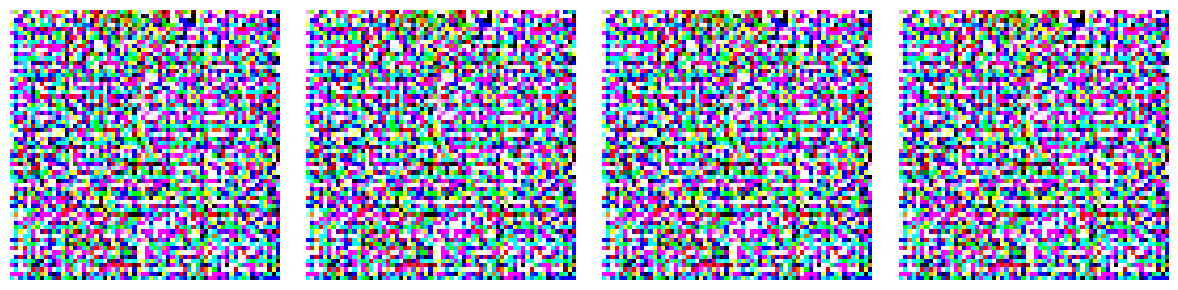

In [14]:
mostrar_imagenes_generadas(generator)

In [ ]:
# Current timestamp
timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
## Make sure everything saves correctly
os.makedirs("models", exist_ok=True)
os.makedirs(timestamp, exist_ok=True)
gan_path = f"models/{timestamp}/GAN.keras"
generator_path = f"models/{timestamp}/Generator.keras"
discriminator_path = f"models/{timestamp}/Discrimiator.keras"

# Save the model
gan.save(gan_path)
generator.save(generator_path)
discriminator.ave(discriminator_path)